<a href="https://colab.research.google.com/github/insaiyancvk/Mad-Artist/blob/main/Style%20Transfer%20high%20res.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive',
            # force_remount = True
)

Mounted at /content/drive


In [9]:
!mv '/content/style transfer.mp4' '/content/drive/MyDrive/Style transfer/big boy landscape/'

mv: cannot move '/content/style transfer.mp4' to '/content/drive/MyDrive/Style transfer/big boy landscape/': No such file or directory


In [ ]:
WORKSPACE = {
    'style_root': '/content/drive/MyDrive/Style Transfer/',
    'train_res': '/content/drive/MyDrive/Style Transfer/train_res'
    }

In [ ]:
import os

In [ ]:
for key, value in WORKSPACE.items():
  if os.path.isdir(value):
    print(f"{value} exists")
  else:
    print(f"{value} doesn't exist. Creating one")
    os.mkdir(value)

/content/drive/MyDrive/Style Transfer/ exists
/content/drive/MyDrive/Style Transfer/train_res exists


In [ ]:
%matplotlib inline
import torch
import torchvision
from torch import nn

In [ ]:
!pip install -q d2l

## Check style and content images

In [ ]:
from d2l import torch as d2l
d2l.set_figsize()
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
content_img = Image.open('/content/drive/MyDrive/Style Transfer/content landscape.jpg')

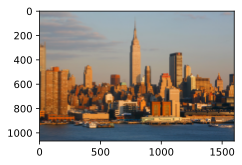

In [ ]:
d2l.plt.imshow(content_img)

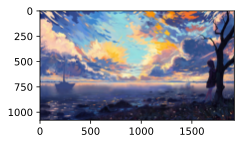

In [ ]:
style_img = Image.open('/content/drive/MyDrive/Style Transfer/style landscape.jpg')
d2l.plt.imshow(style_img)

## Preprocess and postprocess stuff

In [ ]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
  transforms = torchvision.transforms.Compose([
                      torchvision.transforms.Resize(image_shape),
                      torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize(mean = rgb_mean, std=rgb_std)])
  return transforms(img).unsqueeze(0)

def postprocess(img):
  img = img[0].to(rgb_std.device)
  img = torch.clamp(img.permute(1,2,0)* rgb_std + rgb_mean, 0, 1)
  return torchvision.transforms.ToPILImage()(img.permute(2,0,1))

## Feature extraction using VGG-19

In [ ]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [ ]:
# check the style layers
print('Style layers')
for i in style_layers:
  print(pretrained_net.features[i])

print('Content layer')
pretrained_net.features[content_layers[0]]

Style layers
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Content layer


Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
pretrained_net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
net = nn.Sequential(
    *[pretrained_net.features[i] 
      for i in range(max(content_layers+style_layers) + 1)]
    )

In [ ]:
# me trying to understand the purpose of asterisk
n = [pretrained_net.features[i] for i in range(max(content_layers+style_layers) + 1)]
print(*n)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ReLU(inplace=True) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ReLU(inplace=True) MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ReLU(inplace=True) Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ReLU(inplace=True) MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ReLU(inplace=True) Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ReLU(inplace=True) Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ReLU(inplace=True) Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ReLU(inplace=True) MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ReLU(inplace=True

In [ ]:
net

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
def extract_features(X, content_layers, style_layers):
  contents = []
  styles = []

  # extracting and storing output of each layer (like Conv2d, ReLU, MaxPool2d)
  for i in range(len(net)):
    X = net[i](X)

    # Check if the particular layer of the neural network belongs to style or content layer
    if i in style_layers:
      styles.append(X)
    if i in content_layers:
      contents.append(X)
  return contents, styles

In [ ]:
def get_contents(image_shape, device):
  content_X = preprocess(content_img, image_shape).to(device)
  contents_Y, _ = extract_features(content_X, content_layers, style_layers)
  return content_X, contents_Y

def get_styles(image_shape, device):
  style_X = preprocess(style_img, image_shape).to(device)
  _, styles_Y = extract_features(style_X, content_layers, style_layers)
  return style_X, styles_Y

## Define Loss function

In [ ]:
def content_loss(Y_hat, Y):
  return torch.square(Y_hat - Y.detach()).mean()

In [ ]:
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

In [ ]:
def style_loss(Y_hat, gram_Y):
  return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

In [ ]:
def tv_loss(Y_hat):
  return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [ ]:
content_weight, style_weight, tv_weight = 1, 1e3, 1

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
  # Calculate the content, style, and total variance losses respectively
  contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(contents_Y_hat, contents_Y)]
  styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(styles_Y_hat, styles_Y_gram)]
  tv_l = tv_loss(X) * tv_weight
  # Add up all the losses
  # print(tv_l, type(tv_l))

  l = sum(10* styles_l + contents_l, tv_l.tolist())
  return contents_l, styles_l, tv_l, l

In [ ]:
class SynthesizedImage(nn.Module):
  def __init__(self, img_shape, **kwargs):
    super(SynthesizedImage, self).__init__(**kwargs)
    self.weight = nn.Parameter(torch.rand(*img_shape))

  def forward(self):
    return self.weight

In [ ]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [ ]:
try:
  os.mkdir('imgs')
except FileExistsError:
  pass

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch=0.1):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    
    for epoch in tqdm(range(num_epochs+1)):
        trainer.zero_grad()

        contents_Y_hat, styles_Y_hat = extract_features(X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)

        l.backward()
        trainer.step()
        scheduler.step()

        if (epoch + 1) % 400 == 0:
            # plt.imsave('kimino{}.jpg'.format(epoch), postprocess(X))
            print(f"Total loss: {l}")
            animator.axes[1].imshow(postprocess(X))
            # plt.imshow(postprocess(X))
            # plt.show()
            animator.add(epoch + 1, [float(sum(contents_l)),
                                    float(sum(styles_l)), float(tv_l)])
        elif epoch % 10 == 0:
          postprocess(X).save(f'imgs/bigboy_landscape_{epoch}.jpg')
          
    return X

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b42a70b4-8f41-379e-fa9a-798b336b9055)


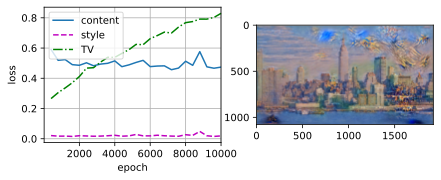

In [ ]:
device, image_shape = d2l.try_gpu(), (1080, 1920) # (240, 426) # (960, 540)  (300, 450)
print(f"Using {device}")
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.09, 10000)

In [ ]:
import imageio

In [ ]:
import os

In [ ]:
imgs_dir = 'imgs/'
images = []
for file_name in sorted(os.listdir(imgs_dir)):
  if file_name.endswith('.jpg'):
    file_path = os.path.join(imgs_dir, file_name)
    images.append(imageio.imread(file_path))
imageio.mimsave('style transfer landscape.gif', images, fps=30)

In [ ]:
del images

In [ ]:
imgss = os.listdir('imgs')

In [ ]:
imgss.sort(key=lambda f: int(re.sub('\D', '', f)))

In [ ]:
import re
# import os
import cv2 
from PIL import Image

In [ ]:
# Video Generating function
def generate_video():
    image_folder = 'imgs/' # make sure to use your folder
    video_name = 'style transfer.avi'
      
    images = [img for img in os.listdir(image_folder)
              if img.endswith(".jpg") or
                 img.endswith(".jpeg") or
                 img.endswith("png")]
     
    # Array images should only consider
    # the image files ignoring others if any
    # print(images) 

    images.sort(key=lambda f: int(re.sub('\D', '', f)))
    frame = cv2.imread(os.path.join(image_folder, images[0]))
  
    # setting the frame width, height width
    # the width, height of first image
    height, width, layers = frame.shape  
  
    video = cv2.VideoWriter(video_name, 0, 60, (width, height)) 
  
    # Appending the images to the video one by one
    for image in images: 
        video.write(cv2.imread(os.path.join(image_folder, image))) 
      
    # Deallocating memories taken for window creation
    cv2.destroyAllWindows() 
    video.release()  # releasing the video generated
generate_video()

In [ ]:
# denoise images
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
!cp imgs/bigboy_landscape_0.jpg .
!cp imgs/bigboy_landscape_10.jpg .
!cp imgs/bigboy_landscape_50.jpg .
!cp imgs/bigboy_landscape_100.jpg .
!cp imgs/bigboy_landscape_500.jpg .
!cp imgs/bigboy_landscape_1000.jpg .
!cp imgs/bigboy_landscape_2000.jpg .
!cp imgs/bigboy_landscape_3000.jpg .
!cp imgs/bigboy_landscape_4000.jpg .
!cp imgs/bigboy_landscape_5000.jpg .
!cp imgs/bigboy_landscape_6000.jpg .
!cp imgs/bigboy_landscape_7000.jpg .
!cp imgs/bigboy_landscape_8000.jpg .
!cp imgs/bigboy_landscape_9000.jpg .
!cp imgs/bigboy_landscape_10000.jpg .

In [ ]:
!cp -r '/content/iter images/' '/content/drive/MyDrive/Style Transfer/train_res'

In [ ]:
imgs = [
  "bigboy_landscape_0.jpg",
  "bigboy_landscape_10.jpg",
  "bigboy_landscape_50.jpg",
  "bigboy_landscape_100.jpg",
  "bigboy_landscape_500.jpg",
  "bigboy_landscape_1000.jpg",
  "bigboy_landscape_2000.jpg",
  "bigboy_landscape_3000.jpg",
  "bigboy_landscape_4000.jpg",
  "bigboy_landscape_5000.jpg",
  "bigboy_landscape_6000.jpg",
  "bigboy_landscape_7000.jpg",
  "bigboy_landscape_8000.jpg",
  "bigboy_landscape_9000.jpg",
  "bigboy_landscape_10000.jpg",
# 'style transfer landscape.gif',
# 'style transfer.avi'
]

try:
  os.mkdir('iter images')
except:
  pass

for i in imgs:
  os.rename(i, 'iter images/'+i)

In [ ]:
# !mv '/content/style transfer.avi' '/content/drive/MyDrive/Style Transfer/big boy landscape'
!mv '/content/iter images' '/content/drive/MyDrive/Style Transfer/big boy landscape pix'
# !zip -r /content/imgs.zip /content/imgs
# from google.colab import files
# files.download("/content/iter_images.zip")

In [ ]:
images = []
for i in imgss:
  images.append(imageio.imread('imgs/'+i))
imageio.mimsave('style transfer.gif', images, fps=30)

In [ ]:
!rm -rf imgs 'iter images'

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
